In [23]:
import pickle as pkl
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
import random
import pickle
import nltk
from collections import Counter
sns.set_palette("colorblind")

# a different layout
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle

# plot and font settings
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none' # Use text for text in SVG
matplotlib.rcParams['pdf.fonttype'] = 42 # Use text for text in PDF

In [4]:
label_dict = {"congress": "Congress",
            "fiction": "Fiction",
            "nyt": "New York Times",
            "caselaw": "Case Law",
            "movie": "Movie",
            "total": "Total"}
            

# Overall Trend

In [5]:
pooling_path = "/zfs/projects/faculty/amirgo-management/code_review_data/pooling/"
df = pd.read_csv(pooling_path+'explicit_trend.csv')
df = df[df['year']>=1950]
# remove fiction data after 2010
df = df[~((df['dataset']=='fiction') & (df['year']>=2010))]

# dataset_size_dict = df['dataset'].value_counts().to_dict()
# dataset_size_dict['total'] = len(df)

/tmp/ipykernel_3823893/4294598072.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(pooling_path+'explicit_trend.csv')


In [6]:
# no legend version
color_dict = {
    'fiction': '#0173b2',
    'nyt': '#de8f05',
    'caselaw': '#029e73',
    'congress': '#d55e00',
    'movie': '#cc78bc',
    'total': '#ca9161'
}

In [7]:
# aggregation
def min_max_normalization(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

def gen_selected_label_proportions(df, label_col, values, sentence_id='sentence_id'):
    datasets = list(df['dataset'].unique())
    datasets.append('total')
    print(datasets)
    ds_proportions = []
    for dataset in datasets:
        if dataset != 'total':
            df_dataset = df[df['dataset'] == dataset]
        else:
            df_dataset = df
        total_sents = df_dataset.groupby('year')[sentence_id].count().reset_index(name='total_sents')
        grouped = df_dataset.groupby(['year', label_col])[sentence_id].count().reset_index(name='counts')
        grouped = grouped.pivot(index='year', columns=label_col, values='counts').reset_index()
        grouped['total_sents'] = total_sents['total_sents']
        for value in values:
            grouped[str(value)+'_prop'] = grouped[value]/grouped['total_sents']
            grouped[str(value)+'_prop_smooth'] =  grouped[str(value)+'_prop'].rolling(10, min_periods=1).mean()
            # normalize
            grouped[str(value)+'_prop_smooth_norm'] = min_max_normalization(grouped[str(value)+'_prop_smooth'])
        grouped['dataset'] = dataset
        ds_proportions.append(grouped)
    
    total_grouped = pd.concat(ds_proportions, axis=0, ignore_index=True)
    return total_grouped

# plot explicit trend with legend
def plot_explicit_trend_nolegend(ground_df, value, value_str):
    datasets = list(ground_df['dataset'].unique())
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    for dataset in datasets:
        df_dataset = ground_df[ground_df['dataset'] == dataset]
        # color blind palette
        color = color_dict[dataset]
        if dataset == 'total':
            ax.plot(df_dataset['year'], df_dataset[str(value)+'_prop_smooth_norm'], label=label_dict[dataset], color=color, linewidth=4)
        else:
            ax.plot(df_dataset['year'], df_dataset[str(value)+'_prop_smooth_norm'], label=label_dict[dataset], color=color, alpha=0.7)

    ax.set_xlabel('Year', fontsize=20)
    ax.set_ylabel('Normalized Proportion', fontsize=20)
    ax.tick_params(axis='both', labelsize=18)

    # Make plot "half open"
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # less tick labels
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))

    plt.show()
    return fig

['congress', 'movie', 'caselaw', 'nyt', 'fiction', 'total']


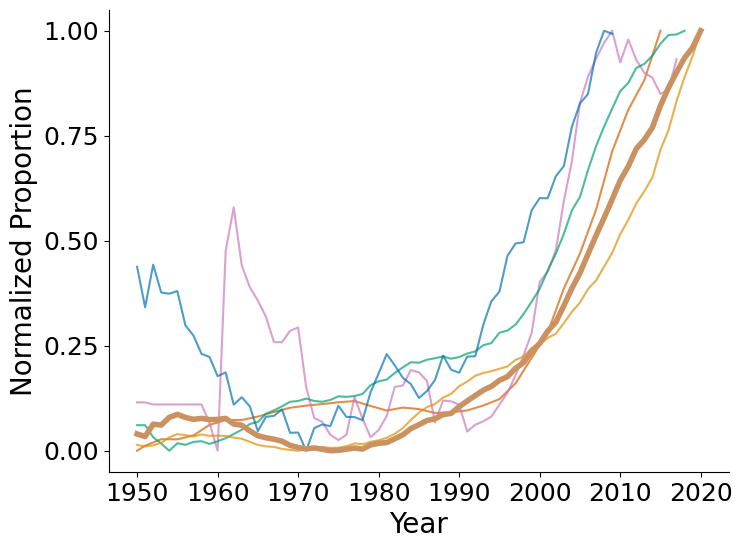

In [8]:
total_grouped = gen_selected_label_proportions(df, 'IsPerson',[1])
fig = plot_explicit_trend_nolegend(total_grouped, 1, 'Personal Management')

In [7]:
data_path = "/zfs/projects/faculty/amirgo-management/code_review_data/figure/"
fig.savefig(data_path+'explicit_plot_nolegend.svg', format='svg', bbox_inches='tight', dpi=300, transparent=True)

# Trend by Domain

In [9]:
def collapse_label(label):
    if label in ['Financials']:
        return "Money"
    elif label in ['Emotion and subjective experiences']:
        return 'Subjectivity'
    elif label in ['Human body']:
        return 'Body'
    elif label in ['Family', 'Friendship', 'Romantic relationships']:
        return 'Relationship'
    elif label in ['Time']:
        return 'Time'
    elif label in ['Household']:
        return 'Household'
    else:
        return 'Others'

df['secondaryLabelSum'] = df['secondaryLabel'].apply(collapse_label)

In [10]:
domain_order = ['Money','Time','Relationship', 'Subjectivity', 'Body']

color_map = {
    'Relationship': '#e79c9c',     # muted red-pink
    'Subjectivity': '#d95c5c',     # dusty rose
    'Body': '#8c2d2d',             # dark brick red
    'Time': '#cccccc',             # mid grey
    'Money': '#888888'             # darker grey
}

def decade_personal_modifier_distribution(df_personal, baseline_df):
    datasets = ['nyt','caselaw','congress','movie','fiction']
    datasets.append('total')
    dataset_proportions = []
    for dataset in datasets:
        if dataset != 'total':
            personal_dataset = df_personal[df_personal['dataset'] == dataset]
            baseline_df_dataset = baseline_df[baseline_df['dataset'] == dataset]
        else:
            personal_dataset = df_personal
            baseline_df_dataset = baseline_df

        category_decade = personal_dataset.groupby(['decade', 'secondaryLabelSum']).size().unstack().fillna(0)
        total_sent_decade = baseline_df_dataset.groupby('decade').size()
        # Ensure consistent column order and drop any missing ones
        category_decade_norm = category_decade.div(total_sent_decade, axis=0)
        present_domains = [cat for cat in domain_order if cat in category_decade_norm.columns]
        category_decade_norm = category_decade_norm[present_domains]
        dataset_proportions.append(category_decade_norm)
    return dataset_proportions

In [19]:
def plot_square_layout(dataset_proportions):
    datasets = ['nyt','caselaw','congress','movie','fiction','total']

    subplot_size = 3
    fig = plt.figure(figsize=(9, 9))
    gs = GridSpec(3, 3, figure=fig, wspace=0.3, hspace=0.3)

    # --- Main plot: spans 2x2 ---
    main_ax = fig.add_subplot(gs[0:2, 0:2])
    main_data = dataset_proportions[-1]
    present_domains = [cat for cat in domain_order if cat in main_data.columns]
    current_colors = [color_map[cat] for cat in present_domains]

    x_locs = range(len(main_data.index))
    main_data.plot(kind='bar', stacked=True, ax=main_ax, color=current_colors, alpha=0.6, legend=False, edgecolor='none')
    main_ax.set_title(label_dict["total"], fontsize=18)
    main_ax.set_ylabel('Explicit Metaphor Proportion', fontsize=14)
    main_ax.set_xlabel('')
    main_ax.set_xticks(x_locs)
    main_ax.set_xticklabels(main_data.index.astype(str), rotation=0, fontsize=12)
    main_ax.tick_params(axis='y', labelsize=12)
    main_ax.spines['top'].set_visible(False)
    main_ax.spines['right'].set_visible(False)

    # # --- Legend in the middle left of the main plot ---
    handles = [
        plt.Rectangle((0, 0), 1, 1, color=color_map[cat], alpha=0.6)
        for cat in present_domains
    ]
    main_ax.legend(
        handles, present_domains,
        title="Management Domains",
        loc='center left',
        bbox_to_anchor=(0.05, 0.5),  # X=5% from left, Y=middle
        fontsize=11,
        title_fontsize=12,
        frameon=False
    )

    # --- Subplots ---
    positions = [(0, 2), (1, 2), (2, 0), (2, 1), (2, 2)]
    for i, dataset in enumerate(datasets[:-1]):
        row, col = positions[i]
        ax = fig.add_subplot(gs[row, col])
        sub_data = dataset_proportions[i]
        present_domains = [cat for cat in domain_order if cat in sub_data.columns]
        current_colors = [color_map[cat] for cat in present_domains]

        x_locs = range(len(sub_data.index))
        sub_data.plot(kind='bar', stacked=True, ax=ax, color=current_colors, alpha=0.6, legend=False,  edgecolor='none')
        ax.set_title(label_dict[dataset], fontsize=12)
        ax.set_xticks(x_locs)
        ax.set_xticklabels([str(year)[-2:] for year in sub_data.index], rotation=0, fontsize=10)
        ax.tick_params(axis='y', labelsize=10)
        ax.set_xlabel('')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    return fig

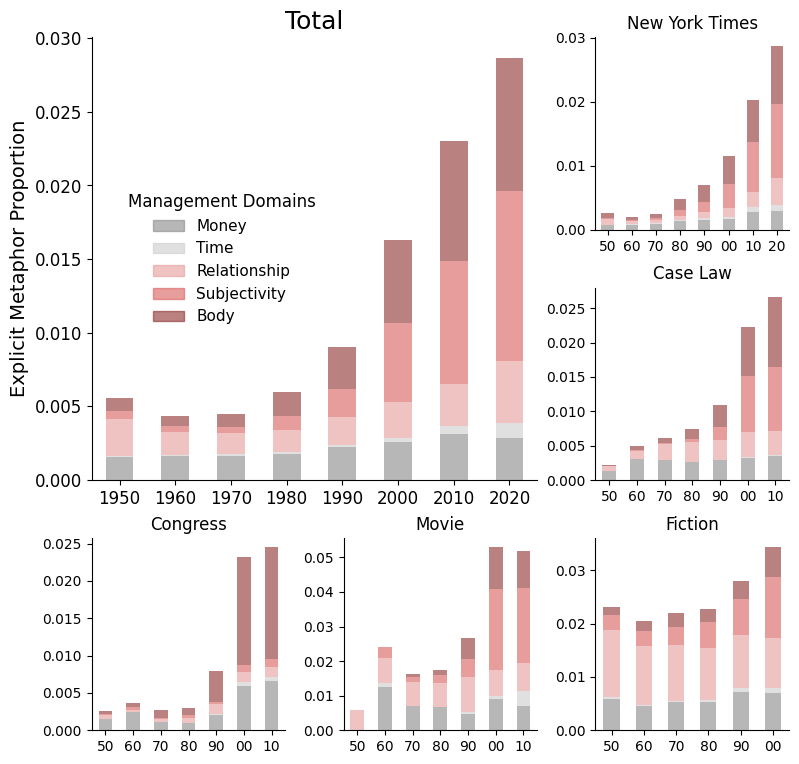

In [24]:
# personal domain distribution
df_personal = df[df['IsPerson'] == 1].copy()
df_personal = df_personal[df_personal['secondaryLabelSum']!='Others']
df_personal['decade'] = df_personal['decade'].astype(int)
personal_domain_proportions = decade_personal_modifier_distribution(df_personal, df)
fig = plot_square_layout(personal_domain_proportions)

In [ ]:
# save as svg
data_path = "/zfs/projects/faculty/amirgo-management/code_review_data/figure/"
fig.savefig(data_path+'explicit_domain_nolegend.svg', format='svg', bbox_inches='tight', dpi=300, transparent=True)

In [25]:
# save as pdf instead of svg
fig.savefig(data_path+'explicit_domain_nolegend.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)